In [1]:
import sqlite3
import random
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense

import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt



2023-07-03 21:28:51.555205: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

con = sqlite3.connect("data/processed_data.db")
cur = con.cursor()
emails = pd.read_sql("Select * from email", con)

In [3]:
emails['label'] = emails['label'].replace({1: 'spam', 0: 'ham'})

spam_emails = emails[emails['label'] == 'spam']
ham_emails = emails[emails['label'] == 'ham']


In [4]:
min_samples = min(len(spam_emails), len(ham_emails))


In [5]:
desired_samples = 25000  # Adjust this number as per your preference
balanced_spam_emails = spam_emails.sample(n=desired_samples, random_state=42)
balanced_ham_emails = ham_emails.sample(n=desired_samples, random_state=42)

In [6]:
balanced_dataset = pd.concat([balanced_spam_emails, balanced_ham_emails], ignore_index=True)
balanced_dataset['spam']=balanced_dataset['label'].apply(lambda x: 1 if x=='spam' else 0)


In [7]:
emails=emails.rename(columns={'label':'spam'})

In [8]:
data = emails.copy()

In [9]:
data = balanced_dataset.copy()

In [10]:
data = data[['spam','email_content']].reset_index()

In [11]:
data['spam'].value_counts(
)

spam
1    25000
0    25000
Name: count, dtype: int64

In [15]:
import re
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def extract_structural_features(email_content):
    body_parts = re.findall(r'Content-Type: multipart', email_content)
    num_body_parts = len(body_parts)

    alternative_parts = re.findall(r'Content-Type: multipart/alternative', email_content)
    num_alternative_parts = len(alternative_parts)

    return num_body_parts, num_alternative_parts

def extract_link_features(email_content):
    links = re.findall(r'<a.*?href="(.*?)".*?>', email_content)
    num_links = len(links)

    ip_links = re.findall(r'<a.*?href="http://\d+\.\d+\.\d+\.\d+.*?".*?>', email_content)
    num_ip_links = len(ip_links)

    deceptive_links = re.findall(r'<a.*?href="(.*?)".*?>.*?</a>', email_content)
    deceptive_links_count = sum(1 for link in deceptive_links if 'http' not in link)

    image_links = re.findall(r'<img.*?src="(.*?)".*?>', email_content)
    num_image_links = len(image_links)

    max_dots = max(link.count('.') for link in links) if links else 0

    words_indicator = any(re.search(r'\b(click|here|login|update)\b', link, re.IGNORECASE) for link in links)

    return num_links, num_ip_links, deceptive_links_count, num_image_links, max_dots, words_indicator

def extract_element_features(email_content):
    is_html = bool(re.search(r'<html', email_content, re.IGNORECASE))

    has_javascript = bool(re.search(r'javascript|onclick', email_content, re.IGNORECASE))

    has_form_tag = bool(re.search(r'<form', email_content, re.IGNORECASE))

    return is_html, has_javascript, has_form_tag

def extract_word_list_features(email_content):
    word_list = ['account', 'update', 'confirm', 'verify', 'secur', 'notif', 'log', 'click', 'inconvenien']
    word_list_indicators = [bool(re.search(r'\b{}\b'.format(word), email_content, re.IGNORECASE)) for word in word_list]

    return word_list_indicators

def preprocess_data(dataset):
    processed_data = []

    for index, row in dataset.iterrows():
        email_content = row['email_content']
        spam = row['spam']

        # Add a check for NaN or missing email_content
        # if pd.isna(email_content):
        #     continue
        #
        structural_features = extract_structural_features(str(email_content))
        link_features = extract_link_features(str(email_content))
        element_features = extract_element_features(str(email_content))
        word_list_features = extract_word_list_features(str(email_content))

        processed_email = [*structural_features, *link_features, *element_features, *word_list_features, spam]
        processed_data.append(processed_email)

    return pd.DataFrame(processed_data, columns=['num_body_parts', 'num_alternative_parts', 'num_links', 'num_ip_links', 'deceptive_links_count', 'num_image_links', 'max_dots', 'words_indicator', 'is_html', 'has_javascript', 'has_form_tag', 'account', 'update', 'confirm', 'verify', 'secur', 'notif', 'log', 'click', 'inconvenien', 'spam'])

# Assuming 'data' is your original DataFrame
df = preprocess_data(data)

# Perform feature normalization
scaler = StandardScaler()
normalized_features = scaler.fit_transform(df.drop('spam', axis=1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(normalized_features, df['spam'], test_size=0.2, random_state=42)

# Build a neural network model
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print("Loss:", loss)
print("Accuracy:", accuracy)


NameError: name 'tf' is not defined

Epoch 1/20
500/500 [==============================] - 9s 15ms/step - loss: 0.4611 - accuracy: 0.7997 - val_loss: 0.3911 - val_accuracy: 0.8341
Epoch 2/20
500/500 [==============================] - 7s 14ms/step - loss: 0.3735 - accuracy: 0.8436 - val_loss: 0.3666 - val_accuracy: 0.8462
Epoch 3/20
500/500 [==============================] - 7s 14ms/step - loss: 0.3632 - accuracy: 0.8481 - val_loss: 0.3646 - val_accuracy: 0.8490
Epoch 4/20
500/500 [==============================] - 7s 14ms/step - loss: 0.3567 - accuracy: 0.8497 - val_loss: 0.3577 - val_accuracy: 0.8431
Epoch 5/20
500/500 [==============================] - 7s 14ms/step - loss: 0.3489 - accuracy: 0.8516 - val_loss: 0.3518 - val_accuracy: 0.8510
Epoch 6/20
500/500 [==============================] - 7s 14ms/step - loss: 0.3407 - accuracy: 0.8568 - val_loss: 0.3571 - val_accuracy: 0.8457
Epoch 7/20
500/500 [==============================] - 7s 14ms/step - loss: 0.3385 - accuracy: 0.8574 - val_loss: 0.3380 - val_accuracy: 0.8566

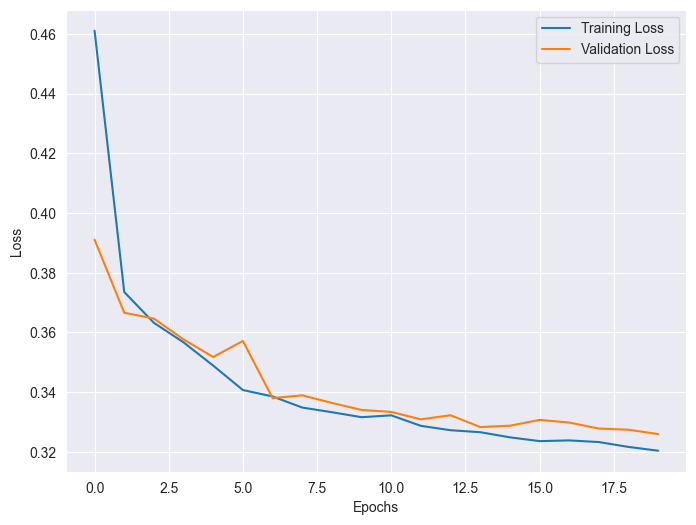

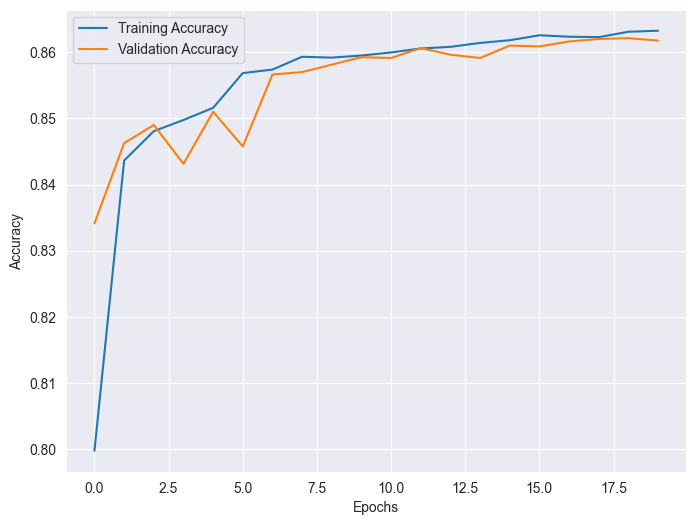

In [94]:
# Perform feature normalization
scaler = StandardScaler()
normalized_features = scaler.fit_transform(df.drop('spam', axis=1))

# Split the data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(normalized_features, df['spam'], test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Build a neural network model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(X_train.shape[1], 1)))  # Assuming input shape is (num_timesteps, num_features)
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with validation data
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=64, verbose=1)



In [13]:
import re
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt



# Split the data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(normalized_features, df['spam'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Build a neural network model
def build_model(hidden_units=128, learning_rate=0.01):
    model = Sequential()
    model.add(LSTM(hidden_units, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Dense(hidden_units, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
# Create the KerasClassifier wrapper
keras_model = KerasClassifier(build_fn=build_model)

# Define the parameter grid for grid search
param_grid = {
    'hidden_units': [32, 64, 128, 256, 512, 1024],
    'learning_rate': [0.001, 0.01, 0.1]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=keras_model, param_grid=param_grid, cv=3)
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_.model

# Train the best model
history = best_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=64, verbose=1)

# Evaluate the best model
loss, accuracy = best_model.evaluate(X_test, y_test, verbose=1)
print("Loss:", loss)
print("Accuracy:", accuracy)

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

/var/folders/vp/bmgsm3216fg61zdd22k8n6jw0000gn/T/ipykernel_54201/3448588049.py:25: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_model = KerasClassifier(build_fn=build_model)


199/667 [=======>......................] - ETA: 2:07 - loss: 0.4894 - accuracy: 0.7789

KeyboardInterrupt: 

In [99]:
import re
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score

from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report



# Split the data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(normalized_features, df['spam'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Build a neural network model
def build_model(hidden_units=128, learning_rate=0.01):
    model = Sequential()
    model.add(LSTM(hidden_units, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Dense(hidden_units, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Create the KerasClassifier wrapper
keras_model = KerasClassifier(build_fn=build_model)

# Define the parameter grid for grid search
param_grid = {
    'hidden_units': [32, 64, 128, 256, 512, 1024],
    'learning_rate': [0.001, 0.01, 0.1]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=keras_model, param_grid=param_grid, cv=3)
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_.model

# Cross-validation with the best model
cv_scores = cross_val_score(best_model, X_train, y_train, cv=3)


print("Cross-validation scores:", cv_scores)

scoring = {'accuracy': 'accuracy', 'roc_auc': 'roc_auc'}
cv_results = cross_validate(best_model, X_train, y_train, cv=3, scoring=scoring)
cv_scores = cv_results['test_accuracy']


# Train the best model
history = best_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=64, verbose=1)

# Evaluate the best model
y_pred = best_model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate metrics
print("Classification Report:")
print(classification_report(y_test, y_pred_binary))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()





/var/folders/vp/bmgsm3216fg61zdd22k8n6jw0000gn/T/ipykernel_12768/3876268784.py:25: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_model = KerasClassifier(build_fn=build_model)


1000/1000 [==============================] - 89s 87ms/step - loss: 0.4120 - accuracy: 0.8255


TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <keras.engine.sequential.Sequential object at 0x7f8e57e55940> does not.

In [14]:
import re
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score

# Split the data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(normalized_features, df['spam'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Build a neural network model
def build_model(hidden_units=128, learning_rate=0.01):
    model = Sequential()
    model.add(LSTM(hidden_units, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Dense(hidden_units, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Create the KerasClassifier wrapper
class CustomKerasClassifier(KerasClassifier):
    def score(self, X, y, **kwargs):
        y_pred = self.predict(X)
        return roc_auc_score(y, y_pred)

keras_model = CustomKerasClassifier(build_fn=build_model)

# Define the parameter grid for grid search
param_grid = {
    'hidden_units': [32, 64, 128, 256, 512, 1024],
    'learning_rate': [0.001, 0.01, 0.1]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=keras_model, param_grid=param_grid, cv=3)
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_.model

# Cross-validation with the best model
cv_scores = cross_val_score(best_model, X_train, y_train, cv=3, scoring='accuracy')
print("Cross-validation scores:", cv_scores)

# Train the best model
history = best_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=64, verbose=1)

# Evaluate the best model
y_pred = best_model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate metrics
print("Classification Report:")
print(classification_report(y_test, y_pred_binary))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


/var/folders/vp/bmgsm3216fg61zdd22k8n6jw0000gn/T/ipykernel_54201/4165368909.py:30: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_model = CustomKerasClassifier(build_fn=build_model)


334/334 [==============================] - 4s 12ms/step


KeyboardInterrupt: 

In [ ]:

import pickle

# Saving the best model
best_model.save("model/spam_model.h5")


# Save the scaler using pickle
with open('model/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
